# STOCHASTIC CLIMATE EMULATORS FOR COASTAL HAZARDS
### UCSC - Nov 2024


<img src="images/Image_3.png" alt="Texto alternativo" width="400">  


## TESLA: 05 - OBTAIN SYNTHETIC DWT TIMESERIES



---

Fernando J.Mendez (fernando.mendez@unican.es)

Full Profesor at the Univeristy of Cantabria

---

Jared Ortiz-Angulo Cantos (ortizanguloj@unican.es)

Researcher

---

Geomatics and Ocean Engineering Group

Civil Engineering School, University of Cantabria

<img src="images/Image_1.png" alt="Texto alternativo" width="200">               <img src="images/Image_2.jpeg" alt="Texto alternativo" width="200">

<img src="images/Image_4.jpeg" alt="Texto alternativo" width="800"> 

© GeoOcean 2024 - University of Cantabria


---

Inputs required:
  * Historical DWTs (Your own Google Drive)
  * Historical AWT and IWT (Your own Google Drive)
  * Synthethic timeseries of AWT and IWT (Your own Google Drive)
  
In this notebook:
  1. Import required libraries and paths
  3. Fit the ALR model of DWT
  4. Generate *n* simulations of 1000 years of DWTs timeseries
  5. Validation


---

## **1. Import required libraries and paths**

In [1]:
import warnings
warnings.filterwarnings('ignore')

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
import pandas as pd

import sys

In [2]:
from bluemath_tk.teslakit.alr import ALR_WRP
from bluemath_tk.teslakit.util.time_operations import xds_reindex_daily, xds_common_dates_daily

from bluemath_tk.teslakit.plotting.estela import Plot_DWTs_Probs
from bluemath_tk.teslakit.plotting.wts import Plot_Probs_WT_WT, Plot_Probs_WT_WT_anomaly
from bluemath_tk.teslakit.plotting.waves import Plot_Waves_DWTs

In [3]:
# paths
p_dat = ('/workspaces/TESLA_UCSC/data')
p_out = ('/workspaces/TESLA_UCSC/results')

alr_path = op.join(p_out,'alr_w_dwt') # path to store ALR results


In [4]:
# --------------------------------------
# load data and set parameters

MJO_fit = xr.open_dataset(op.join(p_dat, 'mjo.nc'))   # historical MJO
KMA_fit = xr.open_dataset(op.join(p_out, 'SLP_KMA.nc'))             # Predictor
PCs_all = xr.open_dataset(op.join(p_out, 'AWT_PCs_from_DWT.nc'))    # SST PCs (annual)

mjo_sim_file = op.join(p_out,'MJO_sim.nc')                          # simulated MJO
MJO_sim_all = xr.open_dataset(op.join(p_out,'MJO_sim.nc'))          # MJO simulations (daily)
PCs_sim_all = xr.open_dataset(op.join(p_out, 'AWT_ALR.nc'))         # AWT simulations (annual)


In [5]:
p_dwt_alr = op.join(p_out, 'DWT_ALR.nc')

---

## **2. FIT THE ALR MODEL OF DWT BASED ON SEASONALITY**

In [6]:
PCs_sim_all = PCs_sim_all.resample(time = '1d').pad()

In [13]:
# ALR fit parameters
alr_num_clusters = 36
alr_markov_order = 3
alr_seasonality = [2, 4, 6]

# ALR simulation
num_sims = 5  # number of simulations

In [14]:
y1_sim = 1900
y2_sim = 2000

In [15]:
PCs_sim_all

<xarray.Dataset> Size: 118MB
Dimensions:     (time: 36890, n_sim: 100)
Coordinates:
  * time        (time) datetime64[ns] 295kB 1899-01-01 1899-01-02 ... 2000-01-01
Dimensions without coordinates: n_sim
Data variables:
    PC1         (n_sim, time) float64 30MB ...
    PC2         (n_sim, time) float64 30MB ...
    PC3         (n_sim, time) float64 30MB ...
    evbmus_sim  (n_sim, time) int64 30MB ...

In [16]:
# --------------------------------------
# Data used to FIT ALR model and preprocess:

# KMA: bmus (daily) (use sorted_bmus_storms, add 1 to get 1-42 bmus set)
BMUS_fit = xr.Dataset(
    {
        'bmus':(('time',), KMA_fit['cluster'].values[:] + 1),
    },
    coords = {'time': KMA_fit.time.values[:]}
)


# MJO: rmm1, rmm2 (daily)
print(MJO_fit)

# SST: PCs (annual)
sst_PCs = PCs_all.PCs.values[:]
PCs_fit = xr.Dataset(
    {
        'PC1': (('time',), sst_PCs[:,0]),
        'PC2': (('time',), sst_PCs[:,1]),
        'PC3': (('time',), sst_PCs[:,2]),
    },
    coords = {'time': PCs_all.time.values[:]}
)

# reindex annual data to daily data
PCs_fit = xds_reindex_daily(PCs_fit)
print(PCs_fit)


<xarray.Dataset> Size: 714kB
Dimensions:  (time: 17839)
Coordinates:
  * time     (time) datetime64[ns] 143kB 1974-06-01 1974-06-02 ... 2023-04-03
Data variables:
    mjo      (time) float64 143kB ...
    phase    (time) int64 143kB ...
    rmm1     (time) float64 143kB ...
    rmm2     (time) float64 143kB ...
<xarray.Dataset> Size: 970kB
Dimensions:  (time: 30317)
Coordinates:
  * time     (time) datetime64[ns] 243kB 1940-01-01 1940-01-02 ... 2023-01-01
Data variables:
    PC1      (time) float64 243kB -0.1048 -0.1048 -0.1048 ... 0.1195 0.2112
    PC2      (time) float64 243kB -0.02446 -0.02446 -0.02446 ... -0.01644 0.1508
    PC3      (time) float64 243kB -0.07235 -0.07235 ... 0.09202 -0.007613


In [17]:
# --------------------------------------
# Mount covariates matrix (model fit: BMUS_fit, MJO_fit, PCs_fit)

# covariates_fit dates
d_fit = xds_common_dates_daily([MJO_fit, PCs_fit, BMUS_fit])

# KMA dates
BMUS_fit = BMUS_fit.sel(time = slice(d_fit[0], d_fit[-1]))

# PCs covars
cov_PCs = PCs_fit.sel(time = slice(d_fit[0], d_fit[-1]))
cov_1 = cov_PCs.PC1.values.reshape(-1,1)
cov_2 = cov_PCs.PC2.values.reshape(-1,1)
cov_3 = cov_PCs.PC3.values.reshape(-1,1)

# MJO covars
cov_MJO = MJO_fit.sel(time = slice(d_fit[0], d_fit[-1]))
cov_4 = cov_MJO.rmm1.values.reshape(-1,1)
cov_5 = cov_MJO.rmm2.values.reshape(-1,1)

# join covars
cov_T = np.hstack((cov_1, cov_2, cov_3, cov_4, cov_5))

# normalize
cov_norm_fit = (cov_T - cov_T.mean(axis=0)) / cov_T.std(axis=0)
cov_fit = xr.Dataset(
    {
        'cov_norm': (('time','n_covariates'), cov_norm_fit),
        'cov_names': (('n_covariates',), ['PC1','PC2','PC3','MJO1','MJO2']),
    },
    coords = {'time': d_fit}
)
print(cov_fit)

<xarray.Dataset> Size: 852kB
Dimensions:    (time: 17747, n_covariates: 5)
Coordinates:
  * time       (time) datetime64[ns] 142kB 1974-06-01 1974-06-02 ... 2023-01-01
Dimensions without coordinates: n_covariates
Data variables:
    cov_norm   (time, n_covariates) float64 710kB -2.551 1.392 ... -0.1289
    cov_names  (n_covariates) <U4 80B 'PC1' 'PC2' 'PC3' 'MJO1' 'MJO2'


In [18]:
# --------------------------------------
# Autoregressive Logistic Regression

# model fit: BMUS_fit, cov_fit, num_clusters
# model sim: cov_sim, sim_num, sim_years

# ALR terms
d_terms_settings = {
    'mk_order'  : alr_markov_order,
    'constant' : True,
    'long_term' : False,
    'seasonality': (True, alr_seasonality),
    'covariates': (True, cov_fit),
}

# ALR wrapper
ALRW = ALR_WRP(alr_path)
ALRW.SetFitData(alr_num_clusters, BMUS_fit, d_terms_settings)

# ALR model fitting
ALRW.FitModel(max_iter=5000)



Fitting autoregressive logistic model ...
Optimization done in 109.40 seconds



/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


---

## **3. GENERATE *n* SIMULATIONS OF 1000 YEARS OF DWT SERIES**

In [19]:
# 20 m!

# --------------------------------------
# Prepare Covariates for ALR simulations

# simulation dates
d_sim = xds_common_dates_daily([MJO_sim_all, PCs_sim_all])

# join covariates for all MJO, PCs simulations
l_cov_sims = []
for i in MJO_sim_all.n_sim:

    # select simulation
    MJO_sim = MJO_sim_all.sel(n_sim=i)
    PCs_sim = PCs_sim_all.sel(n_sim=i)

    # PCs covar
    cov_PCs = PCs_sim.sel(time = slice(d_sim[0], d_sim[-1]))
    cov_1 = cov_PCs.PC1.values.reshape(-1,1)
    cov_2 = cov_PCs.PC2.values.reshape(-1,1)
    cov_3 = cov_PCs.PC3.values.reshape(-1,1)

    # MJO covars
    cov_MJO = MJO_sim.sel(time = slice(d_sim[0], d_sim[-1]))
    cov_4 = cov_MJO.rmm1.values.reshape(-1,1)
    cov_5 = cov_MJO.rmm2.values.reshape(-1,1)

    # join covars (do not normalize simulation covariates)
    cov_T_sim = np.hstack((cov_1, cov_2, cov_3, cov_4, cov_5))
    cov_sim = xr.Dataset(
        {
            'cov_values': (('time','n_covariates'), cov_T_sim),
        },
        coords = {'time': d_sim}
    )
    l_cov_sims.append(cov_sim)

# use "n_sim" name to join covariates (ALR.Simulate() will recognize it)
cov_sims = xr.concat(l_cov_sims, dim='n_sim')
cov_sims = cov_sims.squeeze()

print(cov_sims)

<xarray.Dataset> Size: 146MB
Dimensions:     (n_sim: 100, time: 36525, n_covariates: 5)
Coordinates:
  * time        (time) datetime64[ns] 292kB 1900-01-01 1900-01-02 ... 2000-01-01
Dimensions without coordinates: n_sim, n_covariates
Data variables:
    cov_values  (n_sim, time, n_covariates) float64 146MB -0.1237 ... -0.6253


In [20]:
cov_sims # check it out!

<xarray.Dataset> Size: 146MB
Dimensions:     (n_sim: 100, time: 36525, n_covariates: 5)
Coordinates:
  * time        (time) datetime64[ns] 292kB 1900-01-01 1900-01-02 ... 2000-01-01
Dimensions without coordinates: n_sim, n_covariates
Data variables:
    cov_values  (n_sim, time, n_covariates) float64 146MB -0.1237 ... -0.6253

In [21]:
# --------------------------------------
# Autoregressive Logistic Regression - simulate

# launch simulation
xds_alr = ALRW.Simulate(num_sims, d_sim, cov_sims)

# Store Daily Weather Types
DWT_sim = xds_alr.evbmus_sims.to_dataset()
DWT_sim.to_netcdf(p_dwt_alr)
print(DWT_sim)


ALR model fit   : 1974-06-01 --- 2023-01-01
ALR model sim   : 1900-01-01 --- 2000-01-01

Launching 5 simulations...

Sim. Num. 005 (Covs. 005): 100%|██████████| 36522/36522 [00:21<00:00, 1700.37it/s]

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 36525, n_sim: 5)
Coordinates:
  * time         (time) datetime64[ns] 292kB 1900-01-01 ... 2000-01-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) int64 1MB 31 31 31 31 31 22 ... 10 7 11 17 21 14


---

## **4. VALIDATION**

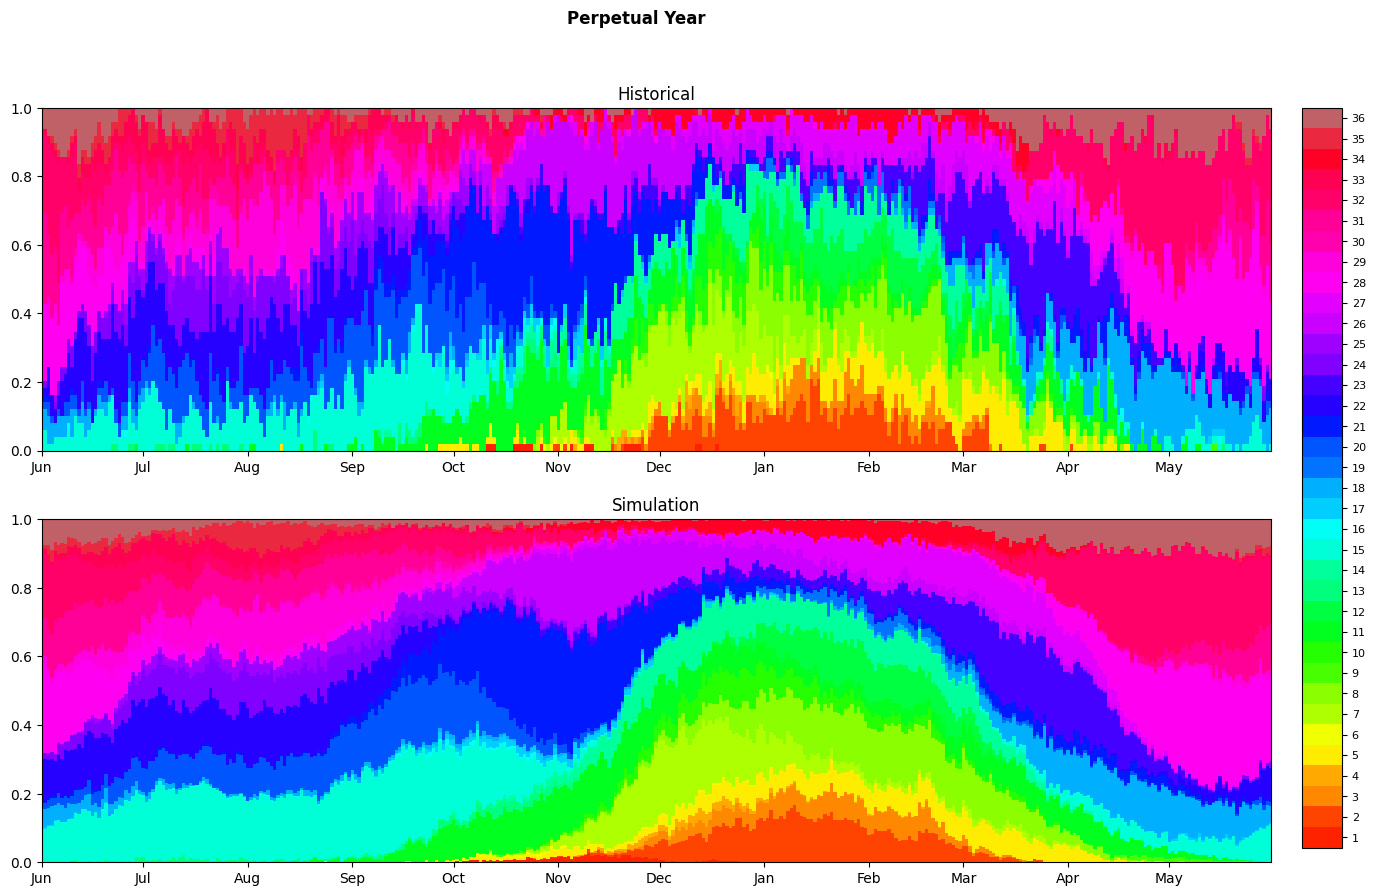

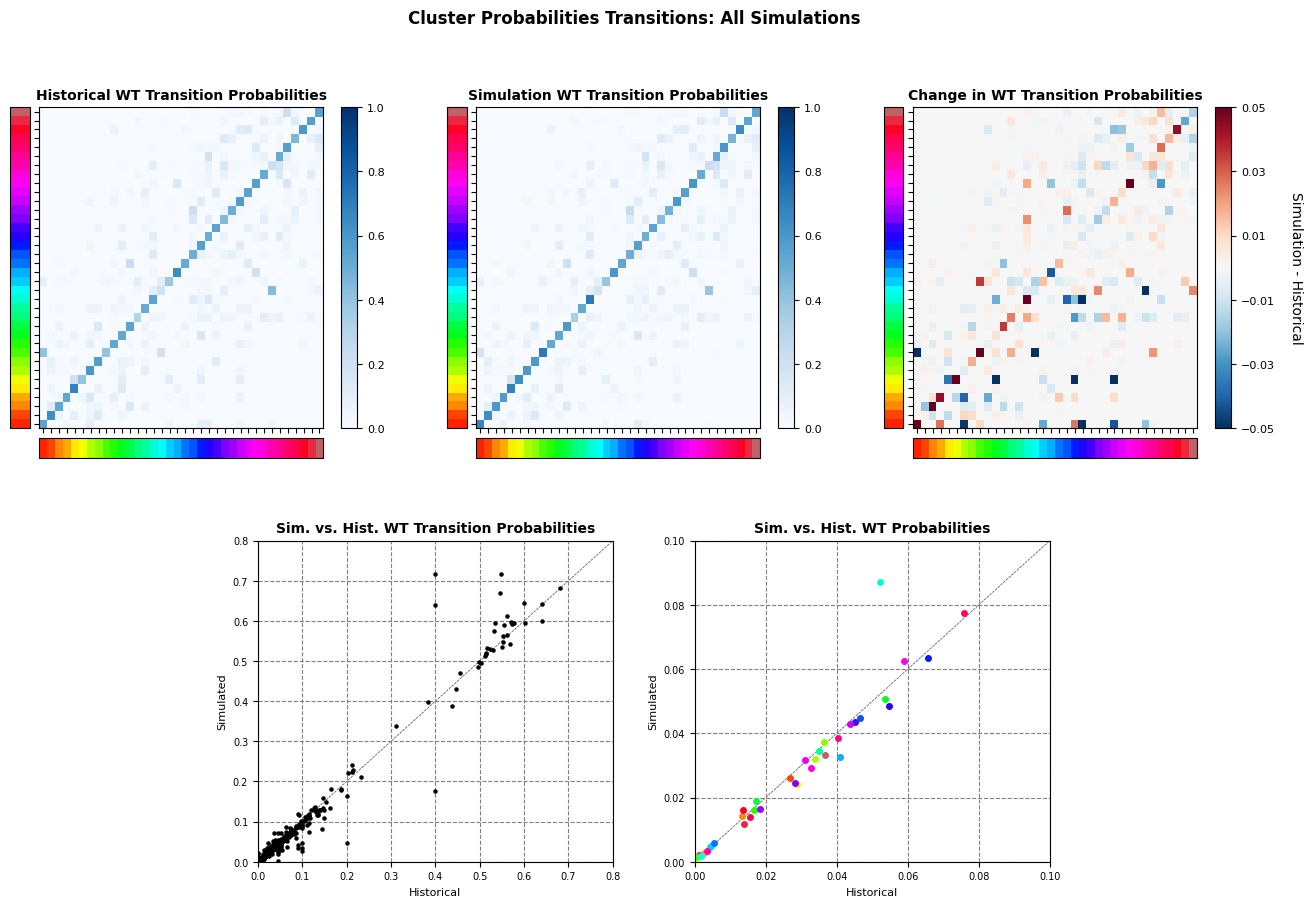

In [22]:
# show sim report
ALRW.Report_Sim(py_month_ini=6);


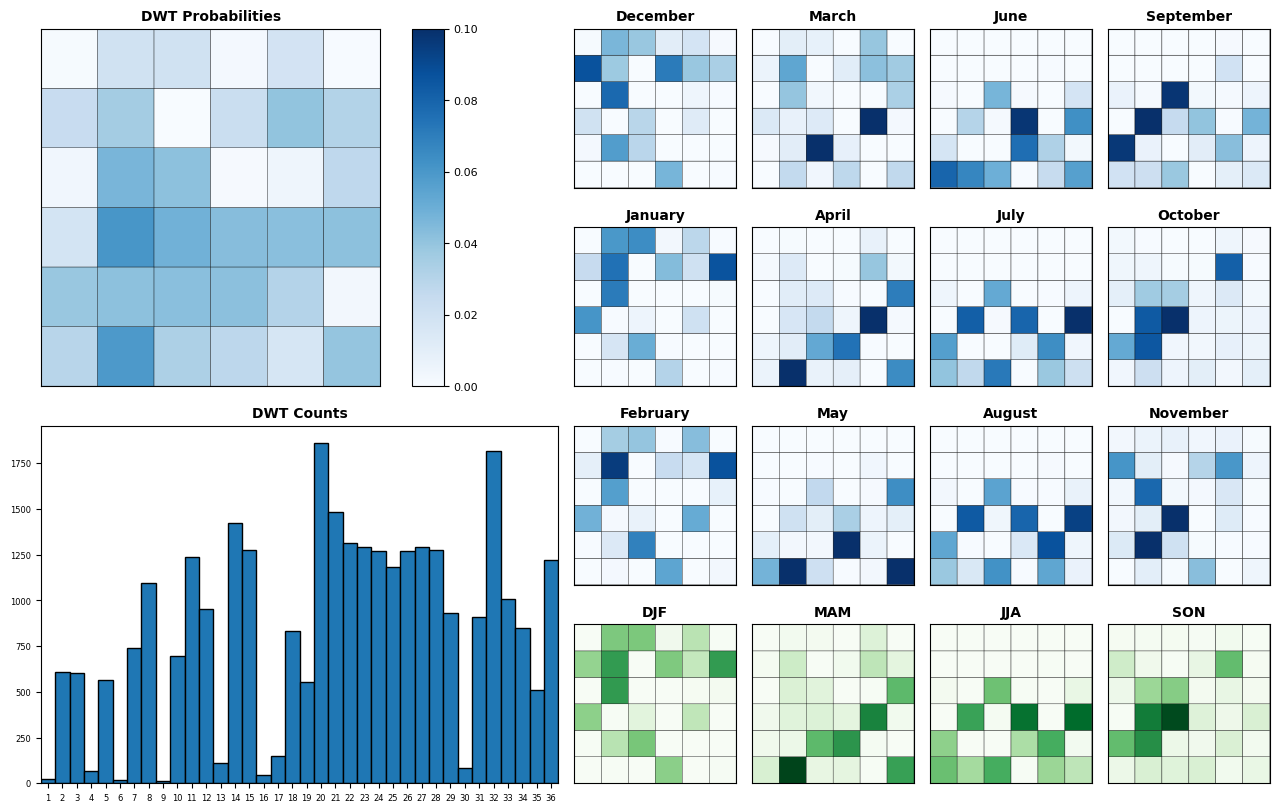

In [23]:
# Plot Historical DWTs probabilities
bmus_fit = KMA_fit.cluster.values[:] + 1
dbmus_fit = KMA_fit.time.values[:]

Plot_DWTs_Probs(bmus_fit, dbmus_fit, alr_num_clusters);

In [24]:
DWT_sim # check it out!

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 36525, n_sim: 5)
Coordinates:
  * time         (time) datetime64[ns] 292kB 1900-01-01 ... 2000-01-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) int64 1MB 31 31 31 31 31 22 ... 10 7 11 17 21 14

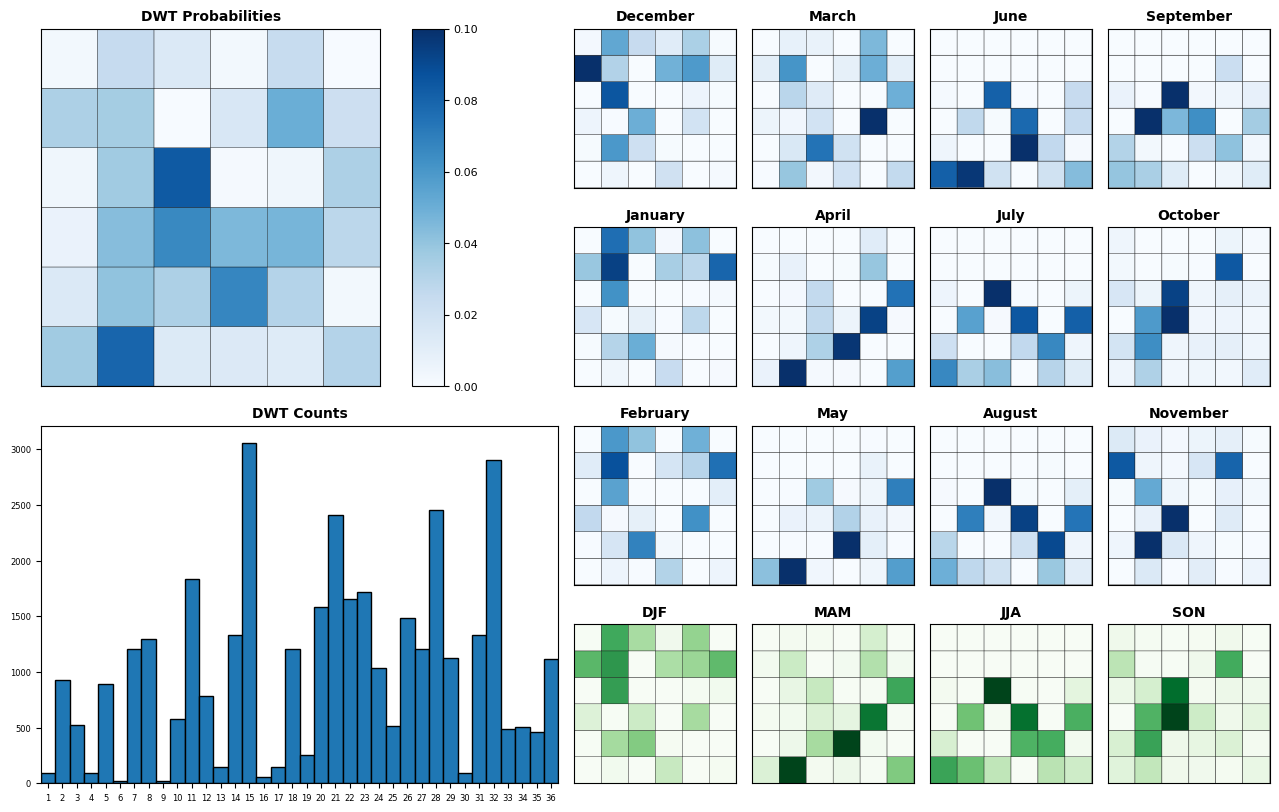

: 

In [ ]:
# Plot Simulated DWTs probabilities
sim = 0

bmus_sim = DWT_sim.isel(n_sim=sim).evbmus_sims.values[:]
dbmus_sim = DWT_sim.time.values[:]


Plot_DWTs_Probs(bmus_sim, dbmus_sim, alr_num_clusters);
